In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv
import seaborn as sns
import matplotlib.pyplot as plt

Using backend: pytorch


In [3]:
dataset = PygNodePropPredDataset(name='ogbn-arxiv', 
                                 root='../../data/dataset/',
                                 transform=T.ToSparseTensor())
dataset

PygNodePropPredDataset()

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_graphsage_linkpred_30_h.npy'
model_path = '../../models/graphsage_link_pred/30_model.pt'
embedding_path = '../../models/graphsage_link_pred/30_embedding.pt'
predictor_path = '../../models/graphsage_link_pred/30_predictor.pt'

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

In [6]:
h = torch.from_numpy(np.load(output_emb_file)).to(device)
h.shape

torch.Size([169343, 50])

In [7]:
data = dataset[0]
data

Data(adj_t=[169343, 169343, nnz=1166243], node_year=[169343, 1], x=[169343, 128], y=[169343, 1])

In [8]:
data.adj_t = data.adj_t.to_symmetric()
data.adj_t

SparseTensor(row=tensor([     0,      0,      0,  ..., 169341, 169342, 169342]),
             col=tensor([   411,    640,   1162,  ..., 163274,  27824, 158981]),
             size=(169343, 169343), nnz=2315598, density=0.01%)

In [9]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LinkPredictor, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def reset_parameters(self):
        self.lin.weight.data.fill_(1)

    def forward(self, x_i, x_j):
        x = x_i * x_j
        x = self.lin(x)
        x = F.relu(x)
        return torch.sigmoid(x)

In [10]:
model = torch.load(model_path)
predictor = torch.load(predictor_path)

In [11]:
predictor(h[0:2], h[411:413])

tensor([[0.9922],
        [0.5000]], device='cuda:0', grad_fn=<SigmoidBackward>)

## Evaluating pred distribution of a node

In [12]:
node_idx = 0

In [13]:
row, col, _ = data.adj_t.coo()
edge_index = torch.stack([col, row], dim=0)
mask = row == node_idx

this_row = row[mask]
this_col = col[mask]

In [14]:
this_row

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

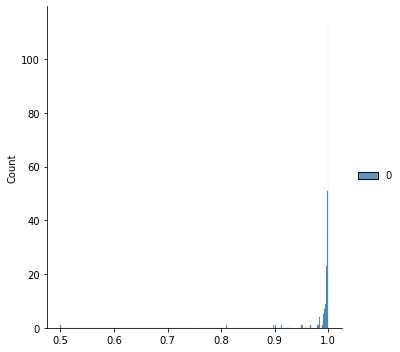

In [15]:
node_preds = predictor(h[this_row], h[this_col]).cpu().detach().numpy()
sns.displot(node_preds)

## Evaluating predictions of all edges

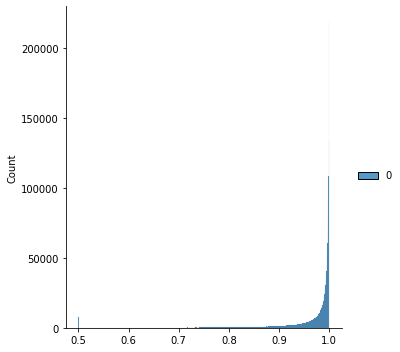

In [16]:
all_edges_preds = predictor(h[row], h[col]).cpu().detach().numpy()
sns.displot(all_edges_preds)

In [17]:
pd.Series(all_edges_preds.squeeze()).describe(percentiles=[0, 0.05, 0.1, 0.25])

count    2.315598e+06
mean     9.638146e-01
std      6.967079e-02
min      5.000000e-01
0%       5.000000e-01
5%       8.244420e-01
10%      8.964244e-01
25%      9.651266e-01
50%      9.911827e-01
max      1.000000e+00
dtype: float64

## Evaluating negative sampling predictions

In [18]:
neg_edges = negative_sampling(edge_index, num_nodes=data.adj_t.size(0),
                              num_neg_samples=100000, method='sparse')

In [19]:
neg_edges[0].size()

torch.Size([100000])

In [20]:
neg_edges_preds = predictor(h[neg_edges[0]], h[neg_edges[1]]).cpu().detach().numpy()

In [21]:
neg_edges_preds.shape

(100000, 1)

In [22]:
neg_edges_preds.max()

1.0

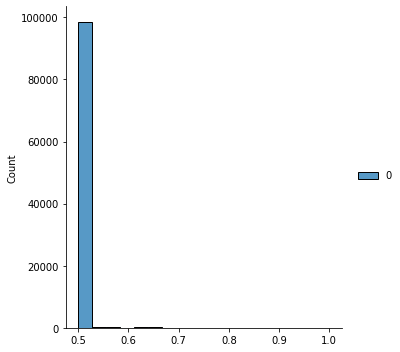

In [23]:
sns.displot(neg_edges_preds.round(4))

In [24]:
pd.Series(neg_edges_preds.squeeze()).describe(percentiles=[0, 0.05, 0.1, 0.25, 0.8, 0.9, 0.95])

count    100000.000000
mean          0.503261
std           0.031955
min           0.500000
0%            0.500000
5%            0.500000
10%           0.500000
25%           0.500000
50%           0.500000
80%           0.500000
90%           0.500000
95%           0.500000
max           1.000000
dtype: float64

## Cosine similarity of all edges

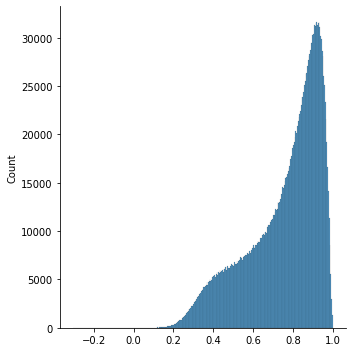

In [25]:
similarities = F.cosine_similarity(h[row], h[col]).cpu().detach().numpy()
sns.displot(similarities)

## Cosine similarity of negative edges

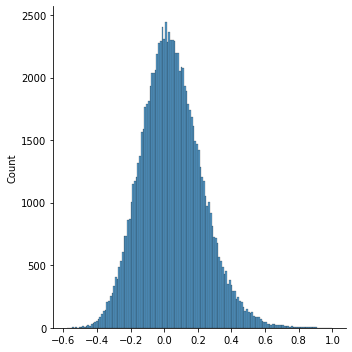

In [26]:
similarities = F.cosine_similarity(h[neg_edges[0]], h[neg_edges[1]]).cpu().detach().numpy()
sns.displot(similarities)